In [9]:
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, time
from PIL import ImageEnhance
from IPython import display
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#load train data from google drive
train_images = np.load('/content/gdrive/MyDrive/train_data.npy')

In [4]:
train_images.shape

(1312, 512, 896, 3)

In [5]:
BUFFER_SIZE = 1312
BATCH_SIZE = 32

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [7]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.2)

#Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(16*28*512,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,28,512)))
    print(model.output_shape)
    assert model.output_shape == (None,16,28,512)

    model.add(layers.Conv2DTranspose(256,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,32,56,256)
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,64,112,128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,128,224,64)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None,256,448,64)
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT,
                                     activation="tanh"))
    
    assert model.output_shape == (None,512,896,3)
    return model

In [8]:
def get_cmap(min_val, max_val):
    orig_cmap = plt.cm.Blues
    colors = orig_cmap(np.linspace(min_val, max_val, 100))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

    return cmap

(None, 16, 28, 512)


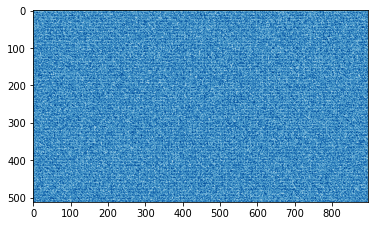

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

cmap = get_cmap(0.33, 0.95)

plt.imshow(generated_image[0, :, :, 0], cmap=cmap)

In [10]:
#Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[512, 896, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.01109437]], shape=(1, 1), dtype=float32)


In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
#set path to google drive folder to save checkpoints while training
checkpoint_dir = '/content/gdrive/MyDrive/sea_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [17]:
EPOCHS = 10400
noise_dim = 100
num_examples_to_generate = 8
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    #generate_and_save_images(generator, epoch + 1, seed)

    # Save checkpoint every n epochs
    if (epoch + 1) % 15 == 0:
      lstdr = os.listdir(checkpoint_dir)

      if len(lstdr) > 10:
        for chfile in lstdr[:-2]:
          if chfile != 'checkpoint':
            os.remove(checkpoint_dir + '/' + chfile)

      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap=cmap)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

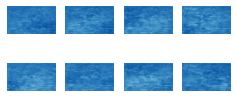

In [22]:
train(train_dataset, 0)

In [ ]:
#save trained model
generator.save('/content/gdrive/MyDrive/sea_checkpoints/seagan.h5')

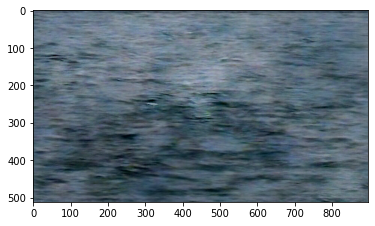

In [30]:
noise = tf.random.normal([1, 100])
#Load saved model and generate image
saved_model = tf.keras.models.load_model('/content/gdrive/MyDrive/sea_checkpoints/seagan.h5')
generated_image = saved_model(noise, training=False)

cmap = get_cmap(0.33, 0.95)

plt.imshow(generated_image._numpy()[0])
#plt.imsave('/content/gdrive/MyDrive/sea_checkpoints/11.png', generated_image._numpy()[0])
#plt.savefig('/content/gdrive/MyDrive/sea_checkpoints/11.png')

In [ ]:
#Normalize image brightness if it's dark
enhancer = ImageEnhance.Brightness(array_to_img(generated_image._numpy()[0]))
pil_image = enhancer.enhance(1)
enhanced_image = np.array(pil_image)
plt.imshow(enhanced_image)